<a href="https://colab.research.google.com/github/catastropiyush/bitbirch/blob/main/dataset_splitting_bitburch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/mqcomplab/bitbirch.git
%cd bitbirch

Cloning into 'bitbirch'...
remote: Enumerating objects: 292, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 292 (delta 44), reused 41 (delta 39), pack-reused 227 (from 1)
Receiving objects: 100% (292/292), 26.16 MiB | 28.59 MiB/s, done.
Resolving deltas: 100% (110/110), done.
/content/bitbirch


In [2]:
!pip install .

Processing /content/bitbirch
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/mqcomplab/iSIM.git to /tmp/pip-install-dflm_h4y/isim_251a836b4359478eb258ec28c9ce925c
  Running command git clone --filter=blob:none --quiet https://github.com/mqcomplab/iSIM.git /tmp/pip-install-dflm_h4y/isim_251a836b4359478eb258ec28c9ce925c
  Resolved https://github.com/mqcomplab/iSIM.git to commit 76325fbd0aa49c4f1f92da24c158a1a89dfd2caf
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/PatWalters/useful_rdkit_utils.git to /tmp/pip-install-dflm_h4y/useful-rdkit-utils_77b976d689904c8d91c172544de0c9c4
  Running command git clone --filter=blob:none --quiet https://github.com/PatWalters/useful_rdkit_utils.git /tmp/pip-install-dflm_h4y/useful-rdkit-utils_77b976d689904c8d91c172544de0c9c4
  Resolved https://github.com/PatWalters/useful_rdkit_utils.git to commit dbddc96d8427c6d26db3339e95dc1c64ec20fd16
  Installing build dependencies ... done
  Getting requirements to build

In [1]:
import bitbirch

In [5]:
import sys
sys.path.append('/content/bitbirch/examples/data_splitting/')
import lgbm_wrapper

In [7]:
import pandas as pd
import useful_rdkit_utils as uru
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator, AllChem
from rdkit.DataStructs import BulkTanimotoSimilarity, ExplicitBitVect
from rdkit.ML.Cluster import Butina
import numpy as np
from tqdm.auto import tqdm
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
# from lgbm_wrapper import LGBMMorganCountWrapper, LGBMBinaryWrapper

from lgbm_wrapper import LGBMPropWrapper, LGBMMorganCountWrapper
from sklearn.metrics import r2_score, mean_absolute_error
import itertools
import time
import bitbirch as bb

In [8]:
df = pd.read_csv("/content/bitbirch/examples/data_splitting/biogen_logS.csv")

In [9]:
df['random_cluster'] = uru.get_random_clusters(df.SMILES)

In [10]:
df['scaffold_cluster'] = uru.get_bemis_murcko_clusters(df.SMILES)

In [11]:
df['butina_cluster'] = uru.get_butina_clusters(df.SMILES)

In [12]:
df['umap_cluster'] = uru.get_umap_clusters(df.SMILES, n_clusters=7)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [13]:
def get_bitbirch_clusters(smiles_list):
    mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
    fps = np.array([Chem.RDKFingerprint(mol) for mol in mols])
    bitbirch = bb.BitBirch(branching_factor=50, threshold=0.65)
    bitbirch.fit(fps)
    cluster_list = bitbirch.get_cluster_mol_ids()

#     # Map each mol ID to its cluster ID
    n_molecules = len(fps)
    cluster_labels = [0] * n_molecules
    for cluster_id, indices in enumerate(cluster_list):
        for idx in indices:
            cluster_labels[idx] = cluster_id
    return cluster_labels

In [16]:
from bitbirch.bitbirch import BitBirch

In [20]:
import sys
sys.path.insert(0, '/content/bitbirch/examples/data_splitting/')
from bitbirch_local import BitBirch

In [22]:
import sys
sys.path.insert(0, '/content/bitbirch/examples/data_splitting/')
from bitbirch_local import BitBirch

import bitbirch_local as bb
bitbirch = bb.BitBirch(branching_factor=50, threshold=0.65)

In [ ]:
#June 27,2025
# changed the name of bitbirch.py to bitbirch_local.py

In [23]:
df['bitbirch_cluster'] = get_bitbirch_clusters(df.SMILES)

In [25]:
size_df = pd.read_csv("/content/bitbirch/examples/data_splitting/biogen_logS.csv")
size_df['mol'] = size_df.SMILES.apply(Chem.MolFromSmiles)
fpgen = rdFingerprintGenerator.GetMorganGenerator()
size_df['fp'] = size_df.mol.apply(fpgen.GetCountFingerprintAsNumPy)
size_df['binary_fps'] = size_df.mol.apply(Chem.RDKFingerprint)

split_list = ["random_cluster","butina_cluster","umap_cluster","scaffold_cluster", "bitbirch_cluster"]
split_dict = {"random_cluster"   : uru.get_random_clusters,
              "butina_cluster"   : uru.get_butina_clusters,
              "umap_cluster"     : uru.get_umap_clusters,
              "scaffold_cluster" : uru.get_bemis_murcko_clusters,
              "bitbirch_cluster" : get_bitbirch_clusters}

result_list =  []
for split in split_list:
    for i in tqdm(range(0,5),desc=split):
        cluster_list = split_dict[split](size_df.SMILES)
        group_kfold_shuffle = uru.GroupKFoldShuffle(n_splits=5, shuffle=True)
        if split == 'bitbirch_cluster':
            for train, test in group_kfold_shuffle.split(np.stack(size_df.binary_fps),size_df.logS,cluster_list):
                result_list.append([split,len(test)])
        else:
            for train, test in group_kfold_shuffle.split(np.stack(size_df.fp),size_df.logS,cluster_list):
                result_list.append([split,len(test)])
result_df = pd.DataFrame(result_list,columns=["split","num_test"])

random_cluster:   0%|          | 0/5 [00:00<?, ?it/s]

butina_cluster:   0%|          | 0/5 [00:00<?, ?it/s]

umap_cluster:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


scaffold_cluster:   0%|          | 0/5 [00:00<?, ?it/s]

bitbirch_cluster:   0%|          | 0/5 [00:00<?, ?it/s]

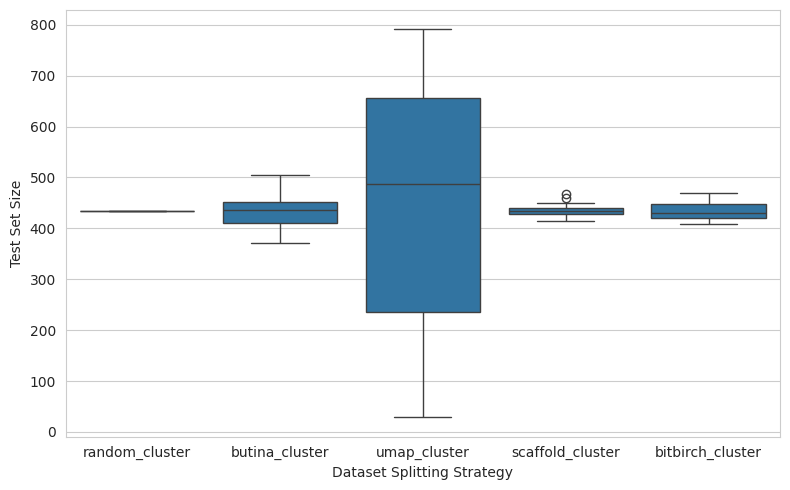

In [26]:
sns.set_style('whitegrid')
plt.figure(figsize=(8,5))
ax = sns.boxplot(x="split",y="num_test",data=result_df)
ax.set_xlabel("Dataset Splitting Strategy")
ax.set_ylabel("Test Set Size")
plt.tight_layout()
plt.show()

In [27]:
urc_result_list = []
for num_clus in tqdm(range(5,76,5)):
    for i in range(0,5):
        cluster_list = uru.get_umap_clusters(size_df.SMILES,n_clusters=num_clus)
        group_kfold_shuffle = uru.GroupKFoldShuffle(n_splits=5, shuffle=True)
        for train, test in group_kfold_shuffle.split(np.stack(size_df.fp),size_df.logS,cluster_list):
            urc_result_list.append([num_clus,len(test)])
urc_result_df = pd.DataFrame(urc_result_list,columns=["num_clus","num_test"])

  0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Text(0, 0.5, 'Number of Test Set Molecules')

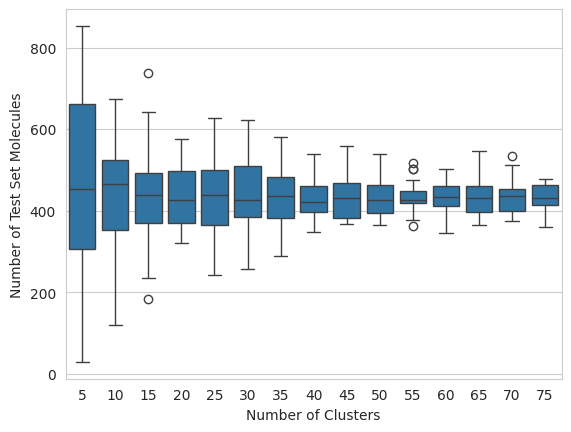

In [28]:
sns.set_style('whitegrid')
ax = sns.boxplot(x="num_clus",y="num_test",data=urc_result_df)
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Number of Test Set Molecules")

In [29]:
def get_tsne_coords(smiles_list):
    fp_gen = rdFingerprintGenerator.GetMorganGenerator()
    mol_list = [Chem.MolFromSmiles(x) for x in smiles_list]
    fp_list = [fp_gen.GetFingerprintAsNumPy(x) for x in mol_list]   #Using binary fingerprints in this test
    pca = PCA(n_components=50)
    pcs = pca.fit_transform(fp_list)
    tsne = TSNE(n_components=2, init='pca', learning_rate='auto')
    res = tsne.fit_transform(pcs)
    tsne_x = res[:,0]
    tsne_y = res[:,1]
    return tsne_x, tsne_y

In [30]:
split_list = ["random_cluster","butina_cluster","umap_cluster","scaffold_cluster", "bitbirch_cluster"]
split_dict = {}
for split in split_list:
    kf = uru.GroupKFoldShuffle(n_splits=5, shuffle=True)
    for train_idx, test_idx in kf.split(df,groups=df[split]):
        split_dict[split] = [train_idx, test_idx]
        break

In [31]:
for k,v in split_dict.items():
    print(k,len(v[0]),len(v[1]))

random_cluster 1738 435
butina_cluster 1823 350
umap_cluster 1409 764
scaffold_cluster 1714 459
bitbirch_cluster 1757 416


In [32]:
tsne_x, tsne_y = get_tsne_coords(df.SMILES)

df['tsne_x'] = tsne_x
df['tsne_y'] = tsne_y

In [33]:
tmp_df = df[['tsne_x','tsne_y']].copy()
tmp_df.reset_index(inplace=True)

In [34]:
split_list = ["random_cluster","butina_cluster","umap_cluster","scaffold_cluster", "bitbirch_cluster"]
for split in split_list:
    tmp_df[split] = "train"
    _, test_idx = split_dict[split]
    for t in test_idx:
        tmp_df[split].at[t] = "test"

In [35]:
tmp_df

,index,tsne_x,tsne_y,random_cluster,butina_cluster,umap_cluster,scaffold_cluster,bitbirch_cluster
0,0,-3.058564,-22.809021,train,train,test,train,train
1,1,-47.426689,-16.877193,train,train,test,train,train
2,2,-14.708849,16.307558,train,test,train,train,train
3,3,6.744595,-31.220514,train,train,test,train,train
4,4,48.236629,-17.895277,train,train,test,test,train
...,...,...,...,...,...,...,...,...
2168,2168,-27.276918,-10.353490,train,train,test,train,train
2169,2169,-15.323755,25.826147,train,train,train,test,train
2170,2170,-6.656963,29.999308,train,train,train,test,train
2171,2171,-26.998657,-41.802593,train,train,train,train,train


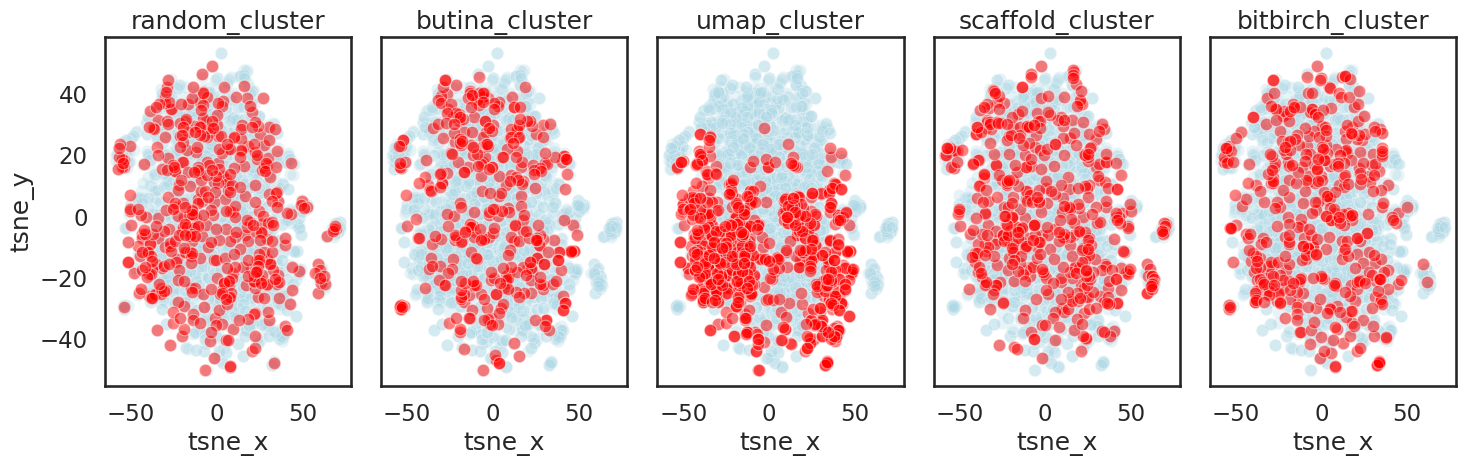

In [36]:
sns.set_style('white')
sns.set_context('talk')
figure, axes = plt.subplots(1,5, figsize=(15,5),sharey=True)
for i,split in enumerate(split_list):
    scatter_ax = sns.scatterplot(x="tsne_x",y="tsne_y",data=tmp_df.query(f"{split} == 'train'"),ax=axes[i],color="lightblue",
                                alpha=0.3, legend=False)
    sns.scatterplot(x="tsne_x",y="tsne_y",data=tmp_df.query(f"{split} == 'test'"),ax=axes[i],color="red",
                                alpha=0.5, legend=False)
    scatter_ax.set_title(split)
plt.tight_layout()

In [37]:
def train_test_tanimoto(train_smiles_list, test_smiles_list, top_n=5):
    fp_gen = rdFingerprintGenerator.GetMorganGenerator()
    train_mol_list = [Chem.MolFromSmiles(x) for x in train_smiles_list]
    train_fp_list = [fp_gen.GetFingerprint(x) for x in train_mol_list]     #Using binary fingerprints in this test
    test_mol_list = [Chem.MolFromSmiles(x) for x in test_smiles_list]
    test_fp_list = [fp_gen.GetFingerprint(x) for x in test_mol_list]
    result_list = []
    for test_fp in test_fp_list:
        sim_list = BulkTanimotoSimilarity(test_fp, train_fp_list)
        sim_array = np.array(sim_list)
        idx = np.argpartition(np.array(sim_array),-top_n)[-top_n:]
        best_n_tanimoto = sim_array[idx]
        result_list.append(best_n_tanimoto)
    return np.array(result_list).flatten()

In [38]:
df_list = []
split_list = ["random_cluster","butina_cluster","umap_cluster","scaffold_cluster", "bitbirch_cluster"]
for split in split_list:
    fold = 0
    idx = 0
    for i in tqdm(range(0,5),desc=split):
        kf = uru.GroupKFoldShuffle(n_splits=5, shuffle=True)
        for train_idx, test_idx in kf.split(df,groups=df[split]):
            train = df.iloc[train_idx]
            test = df.iloc[test_idx]
            sim_vals = train_test_tanimoto(train.SMILES, test.SMILES)
            idx = np.arange(0,len(sim_vals)) + fold*len(sim_vals)
            sim_df = pd.DataFrame({"sim" : sim_vals, "fold" : fold, "split" : split, "idx" : idx })
            fold += 1
            df_list.append(sim_df)

random_cluster:   0%|          | 0/5 [00:00<?, ?it/s]

butina_cluster:   0%|          | 0/5 [00:00<?, ?it/s]

umap_cluster:   0%|          | 0/5 [00:00<?, ?it/s]

scaffold_cluster:   0%|          | 0/5 [00:00<?, ?it/s]

bitbirch_cluster:   0%|          | 0/5 [00:00<?, ?it/s]

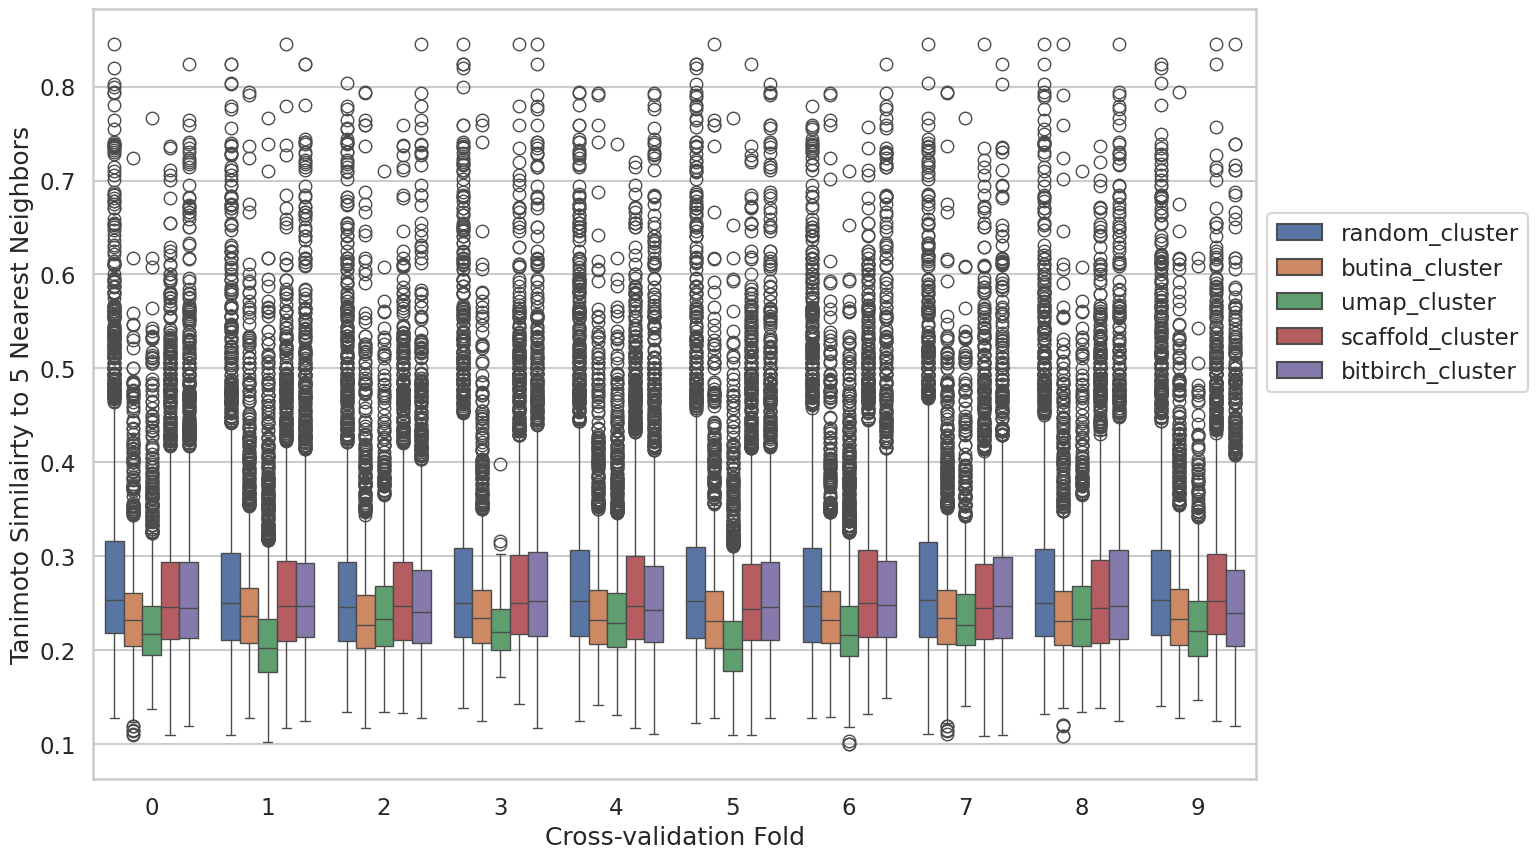

In [39]:
combo_df = pd.concat(df_list)
sns.set(rc={'figure.figsize' : (15,10)})
sns.set_style('whitegrid')
sns.set_context('talk')
ax = sns.boxplot(data=combo_df.query("fold < 10"),x="fold",y="sim",hue="split")
ax.legend(loc='upper left', bbox_to_anchor=(1.00, 0.75), ncol=1)
ax.set_xlabel("Cross-validation Fold")
ax.set_ylabel("Tanimoto Similairty to 5 Nearest Neighbors");

<Axes: xlabel='split', ylabel='sim'>

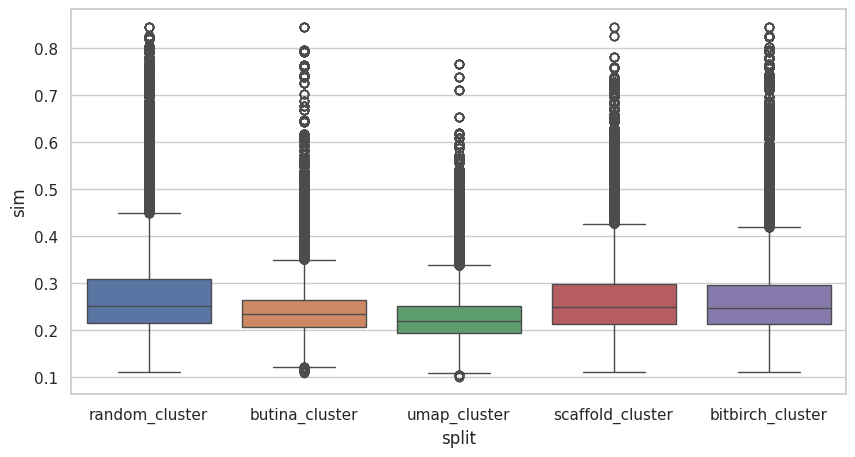

In [40]:
sns.set(rc={'figure.figsize' : (10,5)})
sns.set_style('whitegrid')
sns.boxplot(data=combo_df, x="split", y="sim", hue="split")

In [41]:
tukey_res = pairwise_tukeyhsd(combo_df.sim, combo_df.split)
print(tukey_res)

          Multiple Comparison of Means - Tukey HSD, FWER=0.05           
     group1           group2      meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------
bitbirch_cluster   butina_cluster  -0.0248    0.0 -0.0261 -0.0234   True
bitbirch_cluster   random_cluster   0.0119    0.0  0.0105  0.0133   True
bitbirch_cluster scaffold_cluster   0.0017 0.0071  0.0003  0.0031   True
bitbirch_cluster     umap_cluster  -0.0397    0.0 -0.0411 -0.0383   True
  butina_cluster   random_cluster   0.0367    0.0  0.0353  0.0381   True
  butina_cluster scaffold_cluster   0.0265    0.0  0.0251  0.0279   True
  butina_cluster     umap_cluster  -0.0149    0.0 -0.0163 -0.0135   True
  random_cluster scaffold_cluster  -0.0102    0.0 -0.0116 -0.0088   True
  random_cluster     umap_cluster  -0.0516    0.0  -0.053 -0.0502   True
scaffold_cluster     umap_cluster  -0.0414    0.0 -0.0428   -0.04   True
---------------------------------------------------

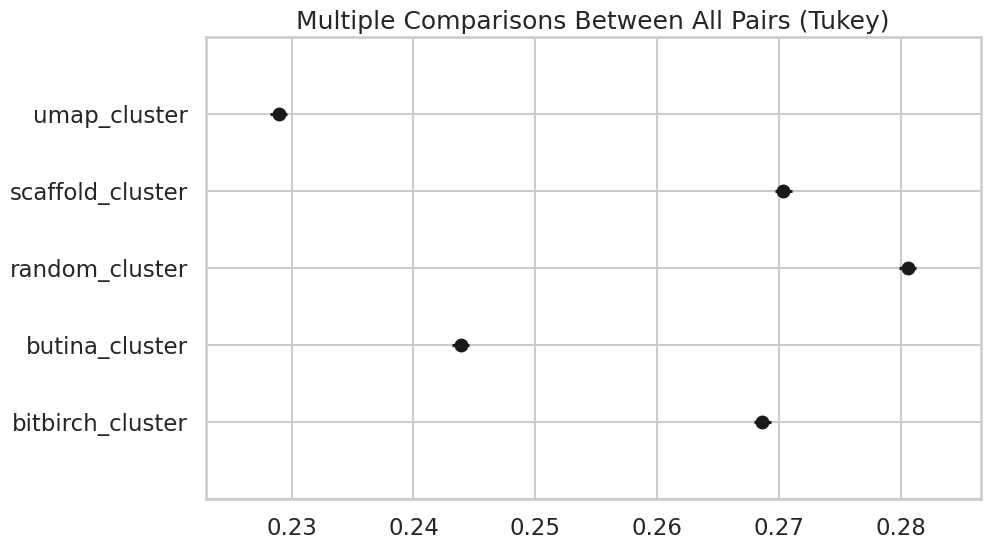

In [42]:
sns.set_style('whitegrid')
sns.set_context('talk')
_ = tukey_res.plot_simultaneous()

In [43]:
model_list = [("lgbm_morgan", LGBMMorganCountWrapper)]
group_list = [("butina", uru.get_butina_clusters), ("random", uru.get_random_clusters),
              ("scaffold", uru.get_bemis_murcko_clusters), ("umap", uru.get_umap_clusters),
              ("bitbirch", get_bitbirch_clusters)]
y = "logS"

In [44]:
result_df = uru.cross_validate(df, model_list, y, group_list, 5, 5)
outfile_name = "biogen_logS_results.csv"
result_df.to_csv(outfile_name, index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

butina:   0%|          | 0/5 [00:00<?, ?it/s]

random:   0%|          | 0/5 [00:00<?, ?it/s]

scaffold:   0%|          | 0/5 [00:00<?, ?it/s]

umap:   0%|          | 0/5 [00:00<?, ?it/s]

bitbirch:   0%|          | 0/5 [00:00<?, ?it/s]

butina:   0%|          | 0/5 [00:00<?, ?it/s]

random:   0%|          | 0/5 [00:00<?, ?it/s]

scaffold:   0%|          | 0/5 [00:00<?, ?it/s]

umap:   0%|          | 0/5 [00:00<?, ?it/s]

bitbirch:   0%|          | 0/5 [00:00<?, ?it/s]

butina:   0%|          | 0/5 [00:00<?, ?it/s]

random:   0%|          | 0/5 [00:00<?, ?it/s]

scaffold:   0%|          | 0/5 [00:00<?, ?it/s]

umap:   0%|          | 0/5 [00:00<?, ?it/s]

bitbirch:   0%|          | 0/5 [00:00<?, ?it/s]

butina:   0%|          | 0/5 [00:00<?, ?it/s]

random:   0%|          | 0/5 [00:00<?, ?it/s]

scaffold:   0%|          | 0/5 [00:00<?, ?it/s]

umap:   0%|          | 0/5 [00:00<?, ?it/s]

bitbirch:   0%|          | 0/5 [00:00<?, ?it/s]

butina:   0%|          | 0/5 [00:00<?, ?it/s]

random:   0%|          | 0/5 [00:00<?, ?it/s]

scaffold:   0%|          | 0/5 [00:00<?, ?it/s]

umap:   0%|          | 0/5 [00:00<?, ?it/s]

bitbirch:   0%|          | 0/5 [00:00<?, ?it/s]

In [45]:
test_df = result_df.query("dset == 'test'")

In [46]:
out_list = []
for k,v in test_df.groupby(["group","fold"]):
    group, fold = k
    r2 = r2_score(v.logS,v.lgbm_morgan)
    out_list.append([group, fold, r2])
out_df = pd.DataFrame(out_list,columns=["split","fold","r2"])

In [47]:
out_df

,split,fold,r2
0,bitbirch,0,0.389845
1,bitbirch,1,0.265346
2,bitbirch,2,0.324398
3,bitbirch,3,0.222918
4,bitbirch,4,0.386031
...,...,...,...
120,umap,20,0.302447
121,umap,21,0.194654
122,umap,22,0.262760
123,umap,23,0.336494


Text(0.5, 0, 'Split')

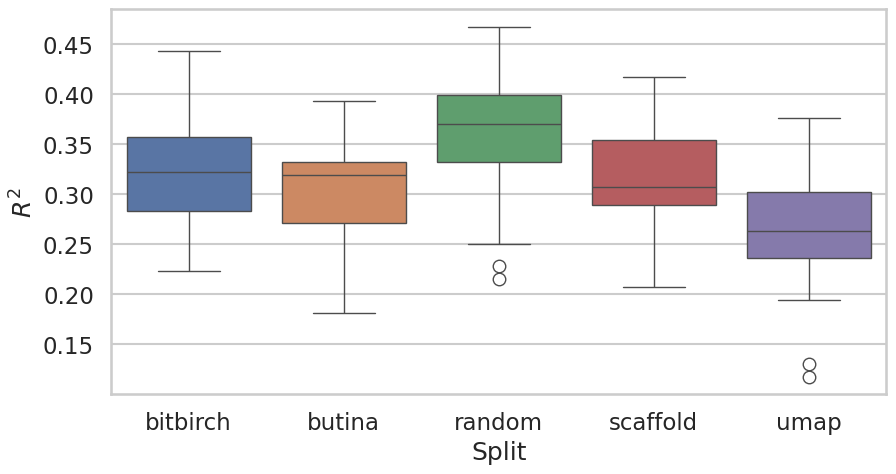

In [48]:
sns.set_style('whitegrid')
ax = sns.boxplot(x="split",y="r2",hue="split",data=out_df)
ax.set_ylabel("$R^2$")
ax.set_xlabel("Split")

In [49]:
tukey_res = pairwise_tukeyhsd(out_df.r2, out_df.split)

In [50]:
print(tukey_res)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2  meandiff p-adj   lower   upper  reject
--------------------------------------------------------
bitbirch   butina  -0.0201 0.7591  -0.067  0.0268  False
bitbirch   random   0.0351 0.2378 -0.0118   0.082  False
bitbirch scaffold  -0.0097 0.9791 -0.0566  0.0372  False
bitbirch     umap  -0.0568 0.0093 -0.1037 -0.0099   True
  butina   random   0.0552 0.0123  0.0083  0.1021   True
  butina scaffold   0.0104 0.9723 -0.0365  0.0573  False
  butina     umap  -0.0367 0.2001 -0.0836  0.0102  False
  random scaffold  -0.0448 0.0687 -0.0917  0.0021  False
  random     umap  -0.0919    0.0 -0.1388  -0.045   True
scaffold     umap  -0.0471 0.0485  -0.094 -0.0002   True
--------------------------------------------------------


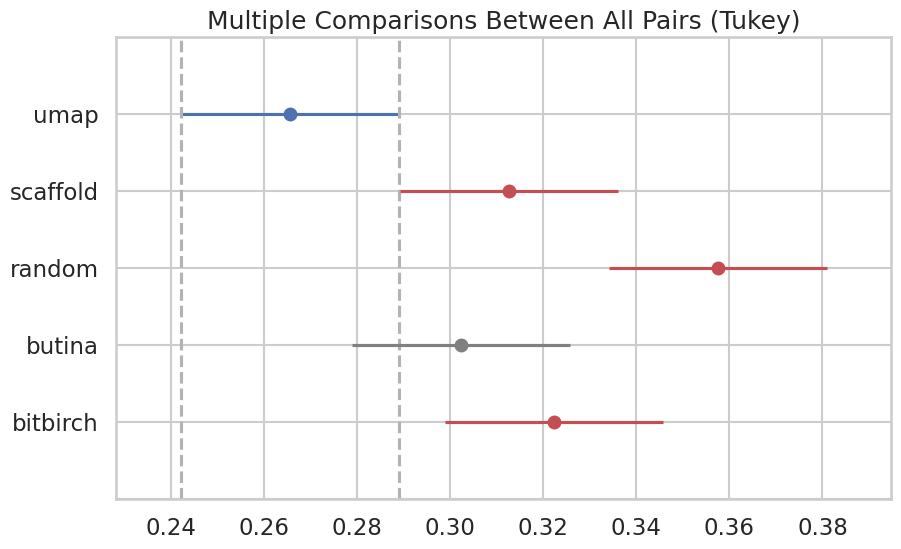

In [51]:
sns.set_style('whitegrid')
sns.set_context('talk')
_ = tukey_res.plot_simultaneous(comparison_name="umap")

In [52]:
def numpy_to_explicit_bitvect(fp):
    bitvect = ExplicitBitVect(len(fp))
    for idx, val in enumerate(fp):
        if val:
            bitvect.SetBit(idx)
    return bitvect

In [53]:
data = np.array(size_df.binary_fps.values.tolist())

# rdkit_fp_list = [fpgen.GetFingerprint(mol) for mol in size_df.mol.values]
rdkit_fp_list = [numpy_to_explicit_bitvect(fp) for fp in data]

In [54]:
s_time = time.time()
bitbirch = bb.BitBirch(branching_factor=50, threshold=0.65)
bitbirch.fit(data)
bitbirch_time = time.time() - s_time
print('Time for BitBIRCH Clustering (s):', bitbirch_time)

dists = []
nfps = len(rdkit_fp_list)
s_time = time.time()
for i in range(1, nfps):
    sims = BulkTanimotoSimilarity(rdkit_fp_list[i], rdkit_fp_list[:i])
    dists.extend([1 - x for x in sims])
cluster_res = Butina.ClusterData(dists, nfps, 0.65, isDistData=True)
butina_time = time.time() - s_time
print('Time for Butina Clustering (s):', butina_time)

Time for BitBIRCH Clustering (s): 0.6798481941223145
Time for Butina Clustering (s): 0.7229812145233154


In [55]:
chembl_fps = np.load('chembl_20Ksample_fps.npy')

chembl_rdkit_fp_list = [numpy_to_explicit_bitvect(fp) for fp in chembl_fps]

FileNotFoundError: [Errno 2] No such file or directory: 'chembl_20Ksample_fps.npy'